# Table of contents

* [Environment set up](#scrollTo=0_Environment_set_up)
* [Dolomities area](#scrollTo=1_Dolomities_area)
* [Nord-Ovest Italy Area](#scrollTo=2_Nord_Ovest_Italy_Area)
    * [Region Level exploration](#scrollTo=2_1_Region_Level_exploration)
    * [Municipality Level exploration](#scrollTo=2_2_Muncipality_level_exploration)

* [Dolomities' Morphology ](#scrollTo=3_Dolomities_Morphology)
    * [Explore the Catalogue Service Web](#scrollTo=3_1_Explore_the_catalogue_Service_Web)
    * [Lakes](#scrollTo=3_2_Lakes)
    * [Glaciers](#scrollTo=3_3_Glaciers)
    * [Marmolada Collapse](#scrollTo=3_3_1_Marmolada_collapse)
    * [Trentino Ortophoto](#scrollTo=3_4_Trentino_Ortophoto)

* [CAI Alpine HUTs](#scrollTo=4_CAI_Alpine_HUT)
    * [Geocoding: from name to location](#scrollTo=4_1_Geocoding_from_name_to_location)
    * [First exploration of the huts](#scrollTo=4_2_First_exploration_of_the_huts)

<br/>
@Gabriele Ghisleni, Data Science.
<br/><hr/>



# &nbsp; 0. Environment set up
Install the required dependecies on google colab and mount the drive. 

In [1]:
%%capture
!pip install -q gwpy

!pip install -U geopandas==0.10.1
!pip install -U geopy==2.2.0
!pip install -U mapclassify==2.4.3
!pip install -U folium
# !pip install pygeos==0.10.2
!pip install owslib==0.25.0
!pip install -U pyshp==2.1.3
!pip install rasterio==1.2.3
!pip install matplotlib==3.1.3

In [2]:
import requests, io, os, fiona, geopy, mapclassify, owslib, warnings, sys, os, folium, rasterio, shapely, json, pprint, shapefile
from folium import FeatureGroup, GeoJson, Marker
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm.auto import tqdm
import geopandas as gpd
import pandas as pd
import numpy as np

drive.mount('/content/drive')
warnings.simplefilter("ignore")
p_print = pprint.PrettyPrinter(indent=4).pprint

# change this to your folder directory
folder_directory = "/content/drive/MyDrive/Geo-Dolomities"
sys.path.append(folder_directory)
os.chdir(folder_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%capture
#download the necessary utils files
if 'geo_utils' not in os.listdir():
  os.mkdir('geo_utils')

if "utils.py" not in os.listdir('geo_utils'):
  url_utils = "https://raw.githubusercontent.com/GabrieleGhisleni/Geo-Dolomities/master/geo_utils/utils.py"
  url_style = "https://raw.githubusercontent.com/GabrieleGhisleni/Geo-Dolomities/master/geo_utils/styles.py"
  !wget --no-cache --backups=1 -P'geo_utils' {url_utils} 
  !wget --no-cache --backups=1 -P'geo_utils' {url_style} 
  !touch utils/__init__.py
  assert 'utils.py' in os.listdir('geo_utils'), 'utils.py not present'
  assert 'styles.py' in os.listdir('geo_utils'), 'styles.py not present'

#in case ModuleError restart the kernel
import geo_utils.utils as utils 
import geo_utils.styles as styles
tiles = 'Stamen Terrain'

# &nbsp; 1. Dolomities area 

Let's explore the area of the dolomities, the data are from the offical website of [Dolomiti Unesco](https://www.dolomitiunesco.info/), that are available in .kml format. 

We load the data and perform some preprocessing before so to have a better insight.


In [4]:
# read kml in GeoPandas https://docs.astraea.earth/hc/en-us/articles/360043923831-Read-a-KML-File-into-a-GeoPandas-DataFrame

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
dolomiti_df = gpd.read_file('data/geo_dolomiti/dolomiti_area.kml', driver='KML')

print(f"Reference system information:\n{ '-'*50}\n{dolomiti_df.crs.__repr__()}{'-'*50}")

Reference system information:
--------------------------------------------------
<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
--------------------------------------------------


In [5]:
# some preprocessing
dolomiti_df["name"] = dolomiti_df["Name"].apply(lambda x: x.replace(',', ' &').replace('\xa0', ' '))
dolomiti_df.loc[2, 'name'] = "Sistema 3 - Pale di San Martino"
dolomiti_df['url_info'] = dolomiti_df.Description.apply(lambda x: x.split('>')[1])

# representative points and area expressed in m^2 (project to 32632 which is in meters).
dolomiti_df['representative_point'] = dolomiti_df.to_crs(epsg=32632).geometry.representative_point().to_crs(epsg=4326)
dolomiti_df['representative_point'] = dolomiti_df['representative_point'].apply(str)
dolomiti_df['area'] = dolomiti_df.to_crs(epsg=32632).geometry.area.apply(lambda x: int(x)) #metersquare since we are in 32632

dolomiti_df = dolomiti_df.loc[:, ['name', 'url_info', 'area', 'representative_point', 'geometry']]
dolomiti_df.head(3)

name  \
0  Sistema 1 - Pelmo & Croda da Lago   
1              Sistema 2 - Marmolada   
2    Sistema 3 - Pale di San Martino   

                                            url_info       area  \
0  http://www.dolomitiunesco.info/?gruppo-dolomit...   43153031   
1  http://www.dolomitiunesco.info/?gruppo-dolomit...   22057860   
2  http://www.dolomitiunesco.info/?gruppo-dolomit...  316567741   

                            representative_point  \
0    POINT (12.08268734287994 46.45014333277591)   
1  POINT (11.859039731003216 46.428646792973986)   
2   POINT (12.165681166978791 46.23429736260587)   

                                            geometry  
0  POLYGON Z ((12.12142 46.40488 0.00000, 12.1214...  
1  POLYGON Z ((11.82319 46.45296 0.00000, 11.8221...  
2  POLYGON Z ((11.98683 46.31720 0.00000, 11.9880...

In [6]:
# Some information regarding the groups and their extensions
for idx, row in dolomiti_df.sort_values('area', ascending=False).reset_index().iterrows():
  print(f"""\
{idx+1}° largest group: '{row["name"]}' Area: {round(row.area * 1e-6)} km2.
Website for more info: {row.url_info}.
  """)

1° largest group: 'Sistema 5 - Dolomiti settentrionali' Area: 536 km2.
Website for more info: http://www.dolomitiunesco.info/?gruppo-dolomitico=dolomiti-settentrionali.
  
2° largest group: 'Sistema 3 - Pale di San Martino' Area: 317 km2.
Website for more info: http://www.dolomitiunesco.info/?gruppo-dolomitico=pale-di-san-martino.
  
3° largest group: 'Sistema 4 - Dolomiti friulane e d'Oltre Piave' Area: 215 km2.
Website for more info: http://www.dolomitiunesco.info/?gruppo-dolomitico=dolomiti-friulane.
  
4° largest group: 'Sistema 9 - Dolomiti di Brenta' Area: 111 km2.
Website for more info: http://www.dolomitiunesco.info/?gruppo-dolomitico=dolomiti-di-brenta.
  
5° largest group: 'Sistema 7 - Sciliar-Catinaccio & Latemar' Area: 93 km2.
Website for more info: http://www.dolomitiunesco.info/?gruppo-dolomitico=sciliar-catinaccio-latemar.
  
6° largest group: 'Sistema 6 - Puez-Odle' Area: 79 km2.
Website for more info: http://www.dolomitiunesco.info/?gruppo-dolomitico=puez-odle.
  
7° l

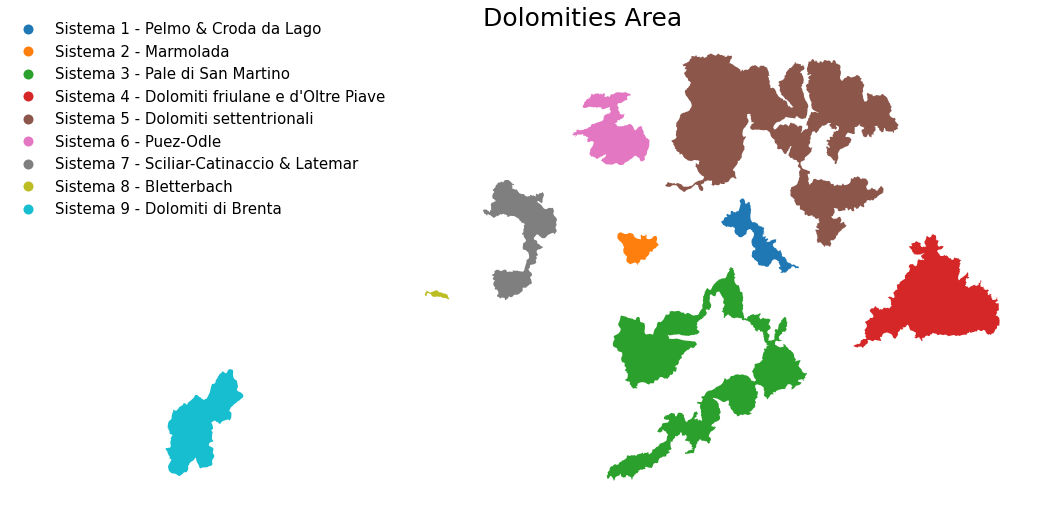

In [7]:
# first representation and plot of the dolomities
fig, axes = plt.subplots(1,1, figsize=(15,15))

dolomiti_df.to_crs(epsg=4326).plot(
    ax=axes,
    column='name',
    cmap = "tab10",
    legend=True,  
    categorical=True,
    legend_kwds= {
        'bbox_to_anchor':(.3, 1.05),
        'fontsize':15,
        'frameon':False
        }
)

plt.title('Dolomities Area', fontdict=dict(size=25))
plt.tight_layout()
plt.axis('off')
plt.show()

# &nbsp; 2. Nord-Ovest Italy Area
Extract the regions of the italy that are closeby the dolomities.


## &nbsp; 2.1 Region level exploration

In [8]:
italy_regions = gpd.read_file("data/istat_administrative.gpkg", layer="regions")

# Set correct crs
italy_regions = italy_regions.to_crs("EPSG:4326")

# Selecting only interested regions
assert italy_regions.crs == dolomiti_df.crs

selected_regions = []
for _, row in dolomiti_df.iterrows():
  regions = italy_regions.geometry.overlaps(row.geometry)
  selected_regions.extend(
      italy_regions.loc[regions].DEN_REG.values.tolist()
  )
  
selected_regions = list(set(selected_regions))
dolomiti_regions = italy_regions.loc[italy_regions.DEN_REG.isin(selected_regions)]

Using Folium library for creating nice interactive maps so to explore the dolomities with respect to the italian regions.

In [9]:
# https://gis.stackexchange.com/questions/392531/modify-geojson-tooltip-format-when-using-folium-to-produce-a-map
# https://stackoverflow.com/questions/58305337/plotting-polygons-in-python-using-geopandas-and-folium
# https://stackoverflow.com/questions/63960271/folium-geojson-custom-color-map
# https://leafletjs.com/reference.html#path-option

dolomiti_map = utils.get_new_map(title='Dolomities in Italy', tiles=tiles)

feature_layers = dict(
  dolomiti_area = FeatureGroup(name='Area Dolomiti'),
  regions_layer = FeatureGroup(name='Italian Regions')   
)

dolomiti_region = GeoJson(
    data = dolomiti_regions,
    style_function = styles.style_region,
    tooltip = folium.GeoJsonTooltip(fields=['DEN_REG'])
  ).add_to(feature_layers["regions_layer"])

dolomiti_geo = GeoJson(
    data = dolomiti_df,
    style_function = styles.style_dolomiti,
    tooltip = folium.GeoJsonTooltip(
            fields=[
                'name',
                'url_info',
                'area',
                'representative_point'
            ])
  )

dolomiti_geo.add_to(feature_layers["dolomiti_area"])
utils.add_map_infos(feature_layers, dolomiti_map, reverse_order=True)

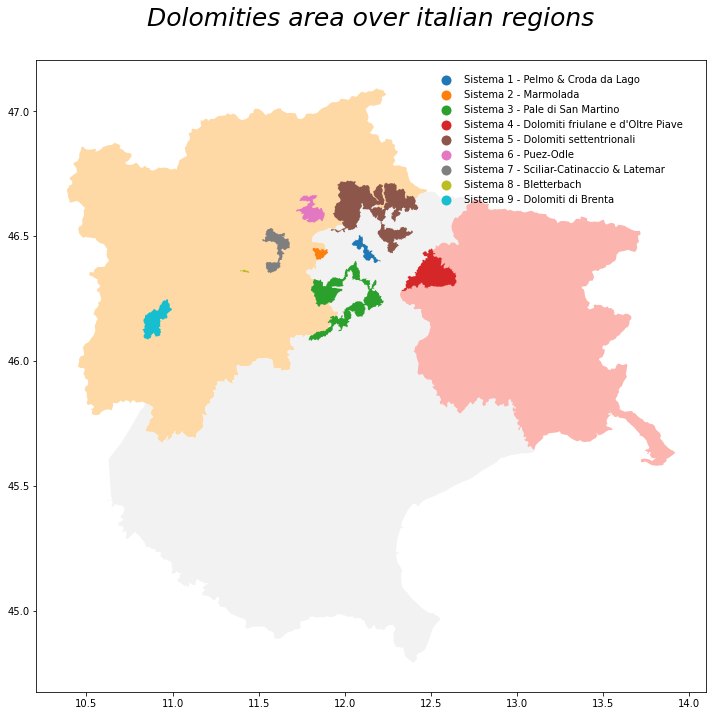

In [10]:
# explore with static maps
fig, axes = plt.subplots(1,1, figsize=(10,15))

dolomiti_regions.to_crs(epsg=4326).plot(
    ax=axes,
    cmap = "Pastel1",
    column='DEN_REG',
    categorical=True,
    legend=True,  
  )

dolomiti_df.to_crs(epsg=4326).plot(
    ax=axes,
    column='name',
    cmap = "tab10",
    legend=True,  
    categorical=True,
    legend_kwds= {
        'bbox_to_anchor':(.98, .99),
        'fontsize':10,
        'frameon':False
        }
  )

plt.title('Dolomities area over italian regions\n', fontdict=dict(size=25, style='italic'))
plt.tight_layout()
# plt.ylim(45.3,47.3)
# plt.xticks([]); plt.yticks([])
# plt.savefig('image/dolomiti_region.jpg', dpi=300)
plt.show()

## &nbsp; 2.2 Muncipality level exploration

In [11]:
italy_municipalities = gpd.read_file("data/istat_administrative.gpkg", layer="municipalities")

# filter by the interested regions
italy_municipalities = italy_municipalities.loc[italy_municipalities.COD_REG.isin(dolomiti_regions.COD_REG.unique())]

# Set correct crs
italy_municipalities = italy_municipalities.to_crs("EPSG:4326")

In [12]:
# find the municipalities that are nearby the dolomities area
def geometry_in_areas(geom, regions_df, attribute_name='name'):
  res = []
  for idx, region in regions_df.iterrows():
    geometry = region.geometry
    if geom.overlaps(geometry): 
      res.append(region[attribute_name])

  return ','.join(res)
  
buffered_dolomiti = dolomiti_df.copy()
buffered_dolomiti.geometry = dolomiti_df.to_crs(epsg=32632).geometry.buffer(500).to_crs(epsg=4326).values

selected_municipalities = italy_municipalities.geometry.apply(lambda x: geometry_in_areas(x, buffered_dolomiti)) # dolomiti_df dolomiti_regions
italy_municipalities['dolomiti'] = selected_municipalities.values
dolomiti_municipalities = italy_municipalities.loc[selected_municipalities != '']
dolomiti_municipalities = dolomiti_municipalities.loc[:, ['COD_REG', 'COMUNE', 'geometry', 'dolomiti']]

dolomiti_municipalities.head(2)

COD_REG  COMUNE                                           geometry  \
2760        4   Badia  MULTIPOLYGON (((11.89993 46.63847, 11.89978 46...   
2763        4  Braies  MULTIPOLYGON (((12.13557 46.73782, 12.13594 46...   

                                               dolomiti  
2760  Sistema 5 - Dolomiti settentrionali,Sistema 6 ...  
2763                Sistema 5 - Dolomiti settentrionali

In [13]:
# add regions of the municipality
dolomiti_municipalities = dolomiti_municipalities.merge(
    dolomiti_regions.loc[:, ['COD_REG', 'DEN_REG']],
    on='COD_REG'
  )

In [14]:
# municipality for each region that touches the dolomities
for _, row in dolomiti_municipalities.groupby('DEN_REG').size().sort_values(0, ascending=False).reset_index().iterrows():
  print(f"'{row.DEN_REG}' has {row[0]} municipalities nearby the dolomities.")

'Trentino-Alto Adige' has 44 municipalities nearby the dolomities.
'Veneto' has 40 municipalities nearby the dolomities.
'Friuli Venezia Giulia' has 6 municipalities nearby the dolomities.


In [15]:
# create the map and add geojson infos
dolomiti_map_municipalities = utils.get_new_map(title='Dolomities over municipalities', tiles='OpenStreetMap')

feature_layers = dict(
  dolomiti_area = FeatureGroup(name='Area Dolomiti'),
  municipalities_layer = FeatureGroup(name='Italian Municipalities')
)

dolomiti_geo.add_to(feature_layers["dolomiti_area"])

GeoJson(
    data = dolomiti_municipalities,
    style_function = styles.style_municipalities,
    tooltip = folium.GeoJsonTooltip(
            fields=[
                'COMUNE',
                'DEN_REG',
                'dolomiti'
            ])
).add_to(feature_layers["municipalities_layer"])

utils.add_map_infos(feature_layers, dolomiti_map_municipalities,  reverse_order=True)

# &nbsp; 3. Dolomities' Morphology 
Explore the morphology of the territory, looking for lakes and glaciers and extracting basics stats.

## &nbsp; 3.1 Explore the Catalogue Service Web

In [16]:
import requests, zipfile, io, os, fiona, geopy, mapclassify, owslib
from owslib.csw import CatalogueServiceWeb
# import shapefile, folium 

# fetch the catalog
csw = CatalogueServiceWeb("http://www.pcn.minambiente.it/geoportal/csw")
query = owslib.fes.PropertyIsLike('csw:AnyText', 'Laghi')
csw.getrecords2(constraints=[query], maxrecords=1_000)

#explore the available data
for i, rec in enumerate(csw.records): 
  print(f"{rec} - {csw.records[rec].title}")
  if i > 15: break

r_campan:16050024:20090806:141714 - Specchi acqua campania
r_piemon:4ba5287d-0c81-4729-84b9-906ad5ccb173 - Idrografia 1:100.000 - Laghi  - Storico
r_vda:03151-META:20170302:081500 - Arpa - Catasto laghi della Valle d'Aosta
r_piemon:60048c12-904a-4aa5-a062-1a9dd94ae971 - Ppr - Laghi (tavv. P4-P5)
p_TN:0403efca-cadb-4463-a656-4d0fba207953 - Aree di protezione dei laghi - Variante PUP 2000
r_piemon:4fb63c5b-813b-4c6d-9fed-6ce92df6ca64 - Ppr - Laghi (tav. P2)
r_basili:54eecefc:162a68d9be7:-2723 - Beni paesaggistici art. 142 let. b - Laghi ed invasi artificiali (Buffer)
ispra_rm:20101021:113000 - Reticolo Idrografico Nazionale - Dataset
r_lombar:36BB78E0-8946-4E7D-ADAC-7D149D18B570 - PTUA 2016 - Tav. 1 - Corpi idrici superficiali e bacini drenanti (fiumi e laghi)
R_SARDEG:XBDOJ - PPR06 - Laghi naturali, invasi artificiali, stagni e lagune
r_campan:16050003:20090722:144054 - Aree di tutela coste e laghi
r_piemon:b65fc959-dfa5-4edd-991d-b6b9f638ab5b - Ppr - Lettera b) fasce lacuali (tav. P2)


## &nbsp; 3.2 Lakes

Explore the lakes in the dolomities.


In [17]:
# explore the resource found
unique_id = "m_amte:299FN3:5237cf1e-4d49-486c-a688-152bc4473508"
dicts = csw.records[unique_id].__dict__

print('Abstract:\n'); print(dicts['abstract']); print('-'*100)
print('References:\n'); p_print(dicts['references']); print('-'*100)
print('Information:\n'); p_print({f"{k}: {v}" for k,v in dicts.items() if v and k != 'xml' and k != 'abstract' and type(v) != list}); print('-'*100)

Abstract:

Elementi poligonali appartenenti al DBPrior10K  rappresentanti gli specchi dacqua interni come laghi, lagune, stagni, bacini artificiali, ecc.
----------------------------------------------------------------------------------------------------
References:

[   {   'scheme': 'urn:x-esri:specification:ServiceType:ArcIMS:Metadata:Server',
        'url': 'http://wms.pcn.minambiente.it/ogc?map=/ms_ogc/WMS_v1.3/Vettoriali/Specchi_Acqua.map'},
    {   'scheme': 'urn:x-esri:specification:ServiceType:ArcIMS:Metadata:Server',
        'url': 'http://www.pcn.minambiente.it/viewer/index.php?services=Laghi_specchi_acqua'},
    {   'scheme': 'urn:x-esri:specification:ServiceType:ArcIMS:Metadata:Server',
        'url': 'http://wms.pcn.minambiente.it/ogc?map=/ms_ogc/wfs/Specchi_Acqua.map&Service=WFS'},
    {   'scheme': 'urn:x-esri:specification:ServiceType:ArcIMS:Metadata:Thumbnail',
        'url': 'http://www.pcn.minambiente.it/anteprima/specchi_acqua.gif'},
    {   'scheme': 'urn:x-esri:s

In [18]:
from owslib.wfs import WebFeatureService

url = "http://wms.pcn.minambiente.it/ogc?map=/ms_ogc/WMS_v1.3/Vettoriali/Specchi_Acqua.map"
wfs = WebFeatureService(url=url, version="1.1.0")

{f"{k}: {v}" for k,v in wfs.__dict__.items() if v and k != 'xml' and k != 'abstract' and type(v) != list}

{'_capabilities: <Element {http://www.opengis.net/wfs}WFS_Capabilities at 0x7f1a3cf17e10>',
 'auth: <Authentication shared=False username=None password=None cert=None verify=True auth_delegate=None>',
 "contents: {'ID.ACQUEFISICHE.SPECCHI.ACQUA': <owslib.feature.wfs110.ContentMetadata object at 0x7f1a38218710>}",
 'filters: <owslib.fes.FilterCapabilities object at 0x7f1a3836a310>',
 'identification: Service: OGC WFS, title=',
 'owscommon: <owslib.ows.OwsCommon object at 0x7f1a3821e490>',
 'provider: <owslib.ows.ServiceProvider object at 0x7f1a3836a1d0>',
 'timeout: 30',
 'url: http://wms.pcn.minambiente.it/ogc?map=%2Fms_ogc%2FWMS_v1.3%2FVettoriali%2FSpecchi_Acqua.map',
 'version: 1.1.0'}

In [19]:
# load the layer as geodataframe
lakes_df = gpd.read_file(
    wfs.getfeature(
    typename="ID.ACQUEFISICHE.SPECCHI.ACQUA",
    bbox = dolomiti_df.total_bounds.tolist(),
  )
)


# invert the xy coordinates
def reverse_geom(geom):
    def _reverse(x, y):
        return y[::-1], x[::-1]

    return shapely.ops.transform(_reverse, geom)


lakes_df.geometry = lakes_df.geometry.apply(reverse_geom)

#buffering 5km the area of dolomities
buffered_dolomiti = dolomiti_df.copy()
buffered_dolomiti.geometry = dolomiti_df.to_crs(epsg=32632).geometry.buffer(5_000).to_crs(epsg=4326).values

# find the lakes in the dolomities area
idxs = []
for idx, row in lakes_df.to_crs(epsg=4326).iterrows():
  if buffered_dolomiti.geometry.contains(row.geometry).sum() > 0:
    idxs.append(idx)

lakes_df = lakes_df.iloc[idxs]
lakes_df = lakes_df.loc[lakes_df.nome != ""].reset_index(drop=True)
lakes_df["area"] = lakes_df.to_crs(epsg=32632).geometry.area
lakes_df["area"] = (lakes_df["area"] * 1e-6).apply(lambda x: round(x, 3))


#biggest lakes
for _, row in lakes_df.sort_values('area', ascending=False).head().iterrows():
  print(f"Name: {row['nome']} area: {row['area']}")

Name: LAGO DI MOLVENO area: 3.218
Name: Lago del Mis area: 1.098
Name: LAGO ARTIFICIALE DI FEDAIA area: 0.545
Name: LAGO DI TOVEL area: 0.371
Name: LAGO DELLO SCHENER area: 0.356


## &nbsp; 3.3 Glaciers

Exploration of all the glaciers that are in the dolomities.

data from http://www.glaciologia.it/en/, thanks to:

*Salvatore M.C., Zanoner T., Baroni C., Carton A., Banchieri F.A., Viani C., Giardino M., Perotti L. (2015) - The state of Italian glaciers: A snapshot of the 2006-2007 hydrological period. Geografia Fisica e Dinamica Quaternaria, 38 (2), pp. 175-198.*

In [20]:
# load the data if present otherwhise download 
if 'ghiacciai.json' not in os.listdir('data'):
  raw_glacier = requests.get('https://repo2.igg.cnr.it/ghiacciaiCGI/data/datagralp.json').json() 

else:
  with open('data/ghiacciai.json') as f:
    raw_glacier = json.load(f)

# set the correct crs
crs = raw_glacier['crs']['properties']['name'].split(':')[-1]
glacier_df =  gpd.GeoDataFrame.from_features(raw_glacier, crs=crs)
glacier_df.to_crs(epsg=4236, inplace=True)

# keeps only the glaciers into the dolomities
idxs = []
for idx, row in glacier_df.to_crs(epsg=4326).iterrows():
  if dolomiti_df.geometry.contains(row.geometry).sum() > 0:
    idxs.append(idx)

glacier_df = glacier_df.iloc[idxs].reset_index(drop=True)
glacier_df["area"] = glacier_df.to_crs(epsg=32632).geometry.area
glacier_df["area"] = (glacier_df["area"] * 1e-6).apply(lambda x: round(x, 3))
glacier_df.head(2)



geometry  \
0  POLYGON ((11.88121 46.25400, 11.88126 46.25399...   
1  POLYGON ((11.87730 46.25057, 11.87733 46.25054...   

                            GLACIER CODE  SUB_CODE      WGI_CODE TIME_STEP  \
0            Ghiacciaio di Fradusta  950         0  IT4L00021001      2006   
1  Ghiacciaio di Fradusta Superiore  950         1          None      2006   

   MAX_ELEV  MIN_ELEV  MAX_LENGTH MEAN_OR  ...  SGROUP  \
0    2770.0    2642.0       426.0       N  ...       A   
1    2887.0    2752.0       249.0       N  ...       A   

                           SGROUP_NAM SUBSECTION SECTION PART AREA_KM     LAT  \
0  Gruppo Pale di San Martino - Feruc      31.IV      31   II    0.07  11.875   
1  Gruppo Pale di San Martino - Feruc      31.IV      31   II    0.04  11.873   

     LONG        DATE   area  
0  46.255  13/09/2006  0.070  
1  46.252  13/09/2006  0.041  

[2 rows x 23 columns]

In [21]:
#biggest glaciers
for _, row in glacier_df.sort_values('area', ascending=False).head().iterrows():
  print(f"Name: {row['GLACIER']} area: {row['area']}, gruppo: {row['GROUP_NAME']}")

print("-"*100)

#group with more glaciers
areas_glacier = glacier_df.groupby('GROUP_NAME').sum().reset_index().loc[:, ['GROUP_NAME', 'area']].sort_values('area', ascending=False)
for _, row in areas_glacier.iterrows():
  print(f'Glacier group: {row.GROUP_NAME} has {round(row.area, 3)} km^2 of glaciers ')

Name: Ghiacciaio Principale della Marmolada area: 1.48, gruppo: Marmolada
Name: Ghiacciaio Superiore (Orientale) dell'Antelao area: 0.255, gruppo: Antelao
Name: Ghiacciaio (Vedretta) del Lagol o de l'Agola area: 0.215, gruppo: Brenta
Name: Ghiacciaio di Travignolo area: 0.194, gruppo: Pale di San Martino
Name: Ghiacciaio Occidentale del Sorapis area: 0.179, gruppo: Sorapiss
----------------------------------------------------------------------------------------------------
Glacier group: Marmolada has 2.025 km^2 of glaciers 
Glacier group: Brenta has 1.124 km^2 of glaciers 
Glacier group: Pale di San Martino has 0.602 km^2 of glaciers 
Glacier group: Sorapiss has 0.453 km^2 of glaciers 
Glacier group: Antelao has 0.404 km^2 of glaciers 
Glacier group: Marmarole has 0.384 km^2 of glaciers 
Glacier group: Cristallo has 0.335 km^2 of glaciers 
Glacier group: Popera has 0.263 km^2 of glaciers 
Glacier group: Pelmo has 0.176 km^2 of glaciers 
Glacier group: Civetta has 0.109 km^2 of glacier

In [22]:
# explore the lakes and the glaciers in the dolomities
glacier_lake_map = utils.get_new_map(title='Glaciers and Lakes', tiles='Stamen Terrain')

feature_layers = dict(
  dolomiti_area = FeatureGroup(name='Area Dolomiti'),
  glacier = FeatureGroup(name='Glacier'),
  lakes = FeatureGroup(name='Lakes'),
)

dolomiti_geo.add_to(feature_layers["dolomiti_area"])

GeoJson(
    data = glacier_df,
    style_function = lambda x : {'color': 'purple', 'fill': True},
    tooltip = folium.GeoJsonTooltip(
              fields=[
                  'GLACIER',
                  'GROUP_NAME',
                  'MAX_ELEV',
                  'MIN_ELEV',
                  'DATE',
                  'AREA_KM'
              ])
  ).add_to(feature_layers["glacier"])


GeoJson(
    data = lakes_df,
    style_function = lambda x : {'color': 'blue', 'fill': True},
    tooltip = folium.GeoJsonTooltip(
              fields=[
                  'nome',
                  'area'
              ])
  ).add_to(feature_layers["lakes"])

utils.add_map_infos(feature_layers, glacier_lake_map)

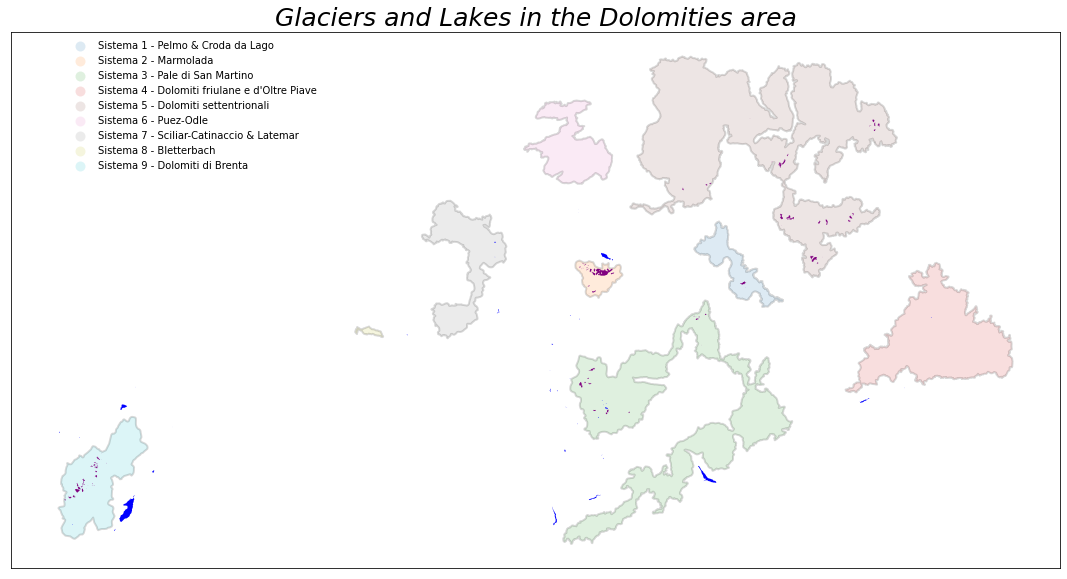

In [23]:
# explore the lakes and the glaciers in the dolomities
import matplotlib.colors as mcolors

fig, axes = plt.subplots(1,1, figsize=(15,15))

dolomiti_df.to_crs(epsg=4326).plot(
    ax=axes,
    linewidth=2,
    edgecolor='black',
    column='name',
    cmap ='tab10',
    alpha=.15,
    legend=True,  
    categorical=True,
    legend_kwds= {
        'bbox_to_anchor':(.3, 1.0),
        'fontsize':10,
        'frameon':False
        }
)



glacier_df.to_crs(epsg=4326).plot(ax=axes, color = "purple")
lakes_df.to_crs(epsg=4326).plot(ax=axes, color = "blue")

plt.title('Glaciers and Lakes in the Dolomities area', fontdict=dict(size=25, style='italic'))
plt.xticks([]); plt.yticks([])
# plt.savefig('image/dolomiti_lakes.jpg', dpi=300)
plt.tight_layout()
plt.show()

## &nbsp; 3.3.1 Marmolada collapse
Brief visualization of the Marmolada' glacier collapse.


sources:

- https://mattinopadova.gelocal.it/regione/2022/07/03/news/incidente-in-marmolada-crolla-una-torre-di-ghiaccio-attivati-cinque-elicotteri-si-cercano-persone-coinvolte-1.41549682

- https://www.ramellasergio.it/Testo/VIE_FUTURE/MARMOLADA/relazione_via_normale_Nord_salita_discesa.html


The details of the graph and network are in the next notebooks.

In [30]:
%%capture
## processed in next notebook
!pip install -U osmnx==1.1.1
import osmnx as ox

# for pale di san martino we have some troubles while retreving the trails.
def custom_maromolada(G_trail):
  geom = dolomiti_df.loc[dolomiti_df['name'] == 'Sistema 2 - Marmolada'].to_crs(epsg=32632).buffer(3_000).to_crs(epsg=4326).values[0]
  nodes, edges = ox.graph_to_gdfs(G_trail)

  nodes = nodes.loc[nodes.geometry.within(geom)]
  edges = edges.loc[edges.geometry.within(geom)]

  return ox.graph_from_gdfs(nodes, edges), edges, nodes

# see notebook 3
G_trail = ox.load_graphml('data/trail_network.graphml.xml')
marolada_trails, edge_gdf, nodes_edge_gdf = custom_maromolada(G_trail)

# marmolada collpase reconstruction
marmolada_collapse = gpd.read_file("data/marmolada_collapse.geojson")
marmolada_collapse['val'] = ['Serraco', 'Trajectory']
marmolada_collapse.loc[marmolada_collapse.val == 'Trajectory', ["geometry"]] = marmolada_collapse.loc[marmolada_collapse.val == 'Trajectory'].to_crs(epsg=32632).buffer(20).to_crs(epsg=4326).values[0]
marmolada_collapse["geometry"] = marmolada_collapse.to_crs(epsg=32632).buffer(5).to_crs(epsg=4326).values

In [33]:
#two nodes individuated before
via_normale =  ox.shortest_path(marolada_trails, 9351573356, 534251272)
trail = utils.route_nodes_to_line_networkx(via_normale, G_trail)

#creating just one df for semplicity 
marmolada_collapse_gdf = edge_gdf.copy()
marmolada_collapse_gdf.reset_index(drop=True, inplace=True)


marmolada_dolomities_df = buffered_dolomiti.loc[dolomiti_df['name'] == 'Sistema 2 - Marmolada']
marmolada_dolomities_df['val'] = 'Marmolada Area'

marmoladas_df = glacier_df.loc[glacier_df.GROUP_NAME  == 'Marmolada']
marmoladas_df = marmoladas_df.loc[~marmoladas_df.CODE.isin(["945", "954", "953a"])]
marmoladas_df['val'] = 'Marmolada Glacier'

final_marmolada = pd.concat([marmolada_collapse_gdf, marmolada_collapse, marmoladas_df])[['val', 'geometry']]

In [34]:
marmolada_map = utils.get_new_map(title='Marmolada Collapse', tiles='Stamen Terrain')

feature_layers = dict(
  trail = FeatureGroup(name='Via Ferrata'),
  trajectory = FeatureGroup(name='Trajectory'),
  serraco = FeatureGroup(name='Serraco'),
  dolomiti_area = FeatureGroup(name='Marmolada'),
)

GeoJson(
    data = marmoladas_df,
    style_function = lambda x : {'color': 'purple', 'fill': False, 'weight':1},
    tooltip = folium.GeoJsonTooltip(fields=['GLACIER'])
  ).add_to(feature_layers["dolomiti_area"])

GeoJson(
    data = final_marmolada.loc[final_marmolada.val == 'Trajectory'],
    style_function = lambda x : {'color': 'blue', 'fill': True, 'fillOpacity':1},
    tooltip = folium.GeoJsonTooltip(fields=['val'])
  ).add_to(feature_layers["trajectory"])

GeoJson(
    data = final_marmolada.loc[final_marmolada.val == 'Serraco'],
    style_function = lambda x : {'color': 'darkblue', 'fill': True, 'fillOpacity':1},
    tooltip = folium.GeoJsonTooltip(fields=['val'])
  ).add_to(feature_layers["serraco"])

folium.PolyLine(
    locations = [list(reversed(i)) for i in list(trail.geometry.values[0].coords)],
    tooltip = "Via Ferrata Normale",
    popup = "Via Ferrata Normale",
    color='lightblue', weight=3,
  ).add_to(feature_layers["trail"])

utils.add_map_infos(feature_layers, marmolada_map)

## &nbsp; 3.4 Trentino Ortophoto

Quickly exploration of the ortophoto of trentino only.

La Provincia Autonoma di Trento ha la piena proprietà dell'ortofoto. Attribuzione 3.0 Italia (CC BY 3.0 IT).

In [35]:
# fetch the catalog
csw = CatalogueServiceWeb("http://geodati.gov.it/RNDT/csw")
trento_query = owslib.fes.PropertyIsLike('csw:AnyText', 'Trento')
csw.getrecords2(constraints=[trento_query], maxrecords=1_000)

#explore the available data
for rec in csw.records: 
  if 'orto' in csw.records[rec].title.lower():
    print(f"{rec} - {csw.records[rec].title}")

agea:00129:20090724:090446 - Ortofotocarta Trento 2003
agea:00377:20090911:093144 - Ortofotocarta Trento 2008
agea:00128:20090724:085449 - Ortofotocarta Trento 1997
c_l378:ortofoto2009 - Ortofoto 2009
p_TN:fbbc1e07-0b8e-46c9-b961-a02d8bebb217 - Ortofoto PAT 1973 in scala di grigi
p_TN:013ef530-ee77-49d2-8f95-035b27ab1f0a - Ortofoto Val di Sella 2007 RGB
p_TN:44cd8a88-ba6e-4299-8075-df9996401006 - Ortofoto Padergnone 2007 RGB
p_TN:e506ab2b-5eb6-452a-8ebb-102ffc4454b1 - Ortofoto Paneveggio 2007 RGB
p_TN:054e1af3-2dd8-4496-8b83-261cccc2674c - Ortofoto Ravina 2007 RGB
p_TN:f2e88f1b-05d9-4942-93ee-857a0a9e1f0b - Ortofoto PAT 2015 RGB


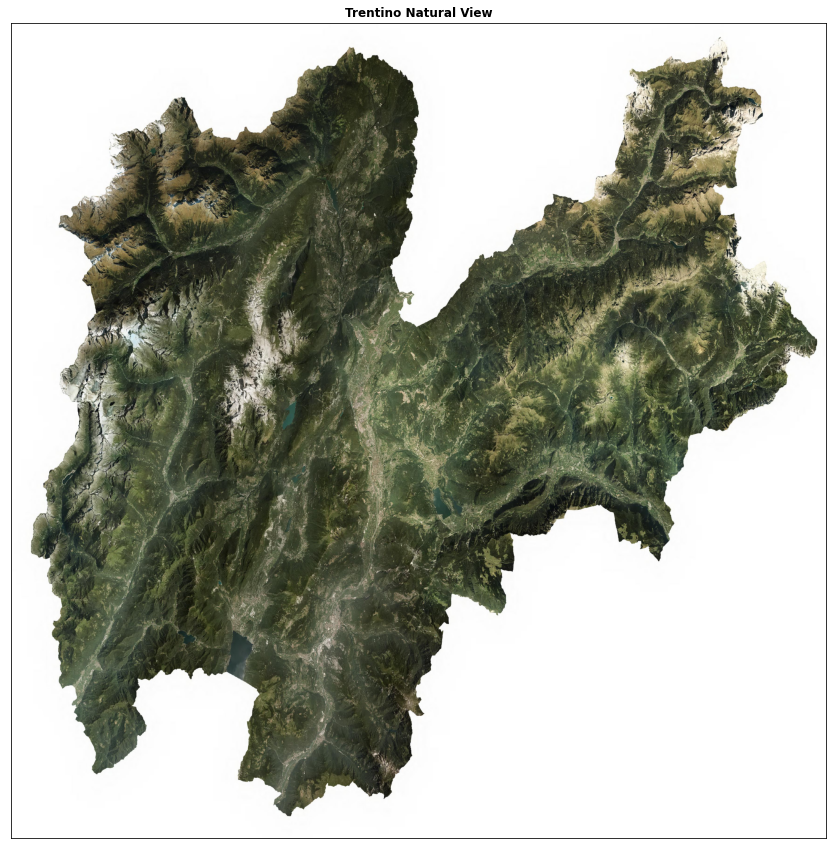

In [36]:
from owslib.wms import WebMapService
from rasterio.plot import show

orto_photo_path = "p_TN:f2e88f1b-05d9-4942-93ee-857a0a9e1f0b"
wms_trento = csw.records[orto_photo_path].__dict__['references'][3]['url']
wms = WebMapService(wms_trento)

trentino_map = wms.getmap(
    layers=['ecw-rgb-2015'],
    srs='EPSG:25832',
    format='image/jpeg',
    bbox=(609500.0, 5056790.0, 731610.0, 5158990.0),
    size=(3500,3500)
  )

fig, axes = plt.subplots(1,1, figsize=(15,15))
fig = show(
    rasterio.MemoryFile(trentino_map).open(),
    ax=axes, 
    title='Trentino Natural View'
)

plt.xticks([]); plt.yticks([])
plt.show()

# &nbsp; 4. CAI Alpine HUT
Manually extract the CAI from the [CAI official website](https://www.cai.it/andare-in-montagna/rifugi-e-bivacchi/rifugi-del-club-alpino-italiano/)  alpine hut and organize them into a useful way. 

In [37]:
# https://www.cai.it/andare-in-montagna/rifugi-e-bivacchi/rifugi-del-club-alpino-italiano/

rifugi_trentino = pd.read_excel(
    io='data/alpine_huts/rifugi_trentino.xlsx', 
    sheet_name=0, 
    header=1
  )

rifugi_veneto = pd.read_excel(
    io='data/alpine_huts/rifugi_veneto.xlsx', 
    sheet_name=0, 
    header=1
  )

rifugi = pd.concat([rifugi_trentino, rifugi_veneto])
rifugi.head(2)

Nome               Tipo Sezione  Quota (m slm)  Posti totali  \
0  Rifugio Vioz  Rifugio custodito  S.A.T.           3535            66   
1   Rifugio Boè  Rifugio custodito  S.A.T.           2873            69   

  Categoria  
0         E  
1         D

## &nbsp; 4.1 Geocoding: from name to location

In [38]:
user_agent = "Mozilla/5.0 (Linux; Android 10) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Mobile Safari/537.36"
geolocator = geopy.geocoders.Nominatim(user_agent=user_agent, timeout=3)

def geocode_sat(rifugi):
  detail = []
  not_founded = []

  for idx, row in tqdm(rifugi.iterrows(), total=len(rifugi)):
    name = row['Nome']
    # manually fix the names that differ
    if name in utils.names_adj:
      name = utils.names_adj[name]

    # geolocate the huts
    geocodes = geolocator.geocode(
            query = name, 
            addressdetails = True,
            extratags = True
          )
    
    if geocodes:
      detail.append(geocodes.raw)
    else:
      not_founded.append(row['Nome'])

  rifugi = utils.expand_raw_geocode(pd.DataFrame(detail))
  rifugi = gpd.GeoDataFrame(rifugi, crs="EPSG:4326")
  rifugi = rifugi.loc[~rifugi.county.isin(['Roma Capitale', "Reggio nell'Emilia", 'Bergamo'])]
  rifugi.drop(columns=['boundingbox']).to_file('data/alpine_huts/rifugi_cai.shp') 
  return rifugi
  

cai_rifugi = (
    gpd.read_file("data/alpine_huts/rifugi_cai.shp") 
    if os.path.exists('data/alpine_huts/rifugi_cai.shp')
    else geocode_sat(rifugi)
  )

cai_rifugi.head(2)

municipali               county  \
0  Comunità della Valle di Sole  Provincia di Trento   
1      Pustertal - Val Pusteria      Bolzano - Bozen   

                          state                           road_name  \
0  Trentino-Alto Adige/Südtirol                                Vioz   
1  Trentino-Alto Adige/Südtirol  Cresta Strenta - Lichtenfelser Weg   

                extended_n     opening_ho       contact_mo winter_roo  \
0  Rifugio Mantova al Vioz  Jun 20-Sep 20  +39 339 2798826        yes   
1              Rifugio Boé  Jun 20-Sep 20  +39 349 5730110        yes   

  capacity                     website                 email  \
0       30  http://www.rifugiovioz.it/   info@rifugiovioz.it   
1       69   http://www.rifugioboe.it/  rifugioboe@gmail.com   

                                          display_na  type_descr  \
0  Rifugio Mantova al Vioz, Vioz, Peio, Comunità ...  alpine_hut   
1  Rifugio Boé, Cresta Strenta - Lichtenfelser We...  alpine_hut   

                    geometry  
0  POINT (10.63578 46.39920)  
1  POINT (11.82328 46.51461)

## &nbsp; 4.2 First exploration of the huts

In [39]:
sat_map = utils.get_new_map(title='Hut mantained by SAT', tiles=tiles)

unique_provice_dolomities = cai_rifugi.county.unique().tolist()
colors = ['gray', 'lightgreen', 'green', 'orange', 'darkred','black']

feature_layers = {
    group:FeatureGroup(name=f"<span style='color:{utils.c_colors[idx]}'>Hut in {group}</span>") 
    for idx, group in enumerate(unique_provice_dolomities)
  }

feature_layers["dolomiti_area"] = FeatureGroup(name='Area Dolomiti')
dolomiti_geo.add_to(feature_layers["dolomiti_area"])

for idx, row in cai_rifugi.iterrows():
  marker = Marker(
      location = [i[0] for i in reversed(row.geometry.xy)],
      popup = utils.get_info_from_row(row),
      tooltip = utils.get_info_from_row(row),
      icon = folium.Icon(color= utils.c_colors[unique_provice_dolomities.index(row.county)])
  )

  marker.add_to(feature_layers[row.county])


utils.add_map_infos(feature_layers, sat_map)

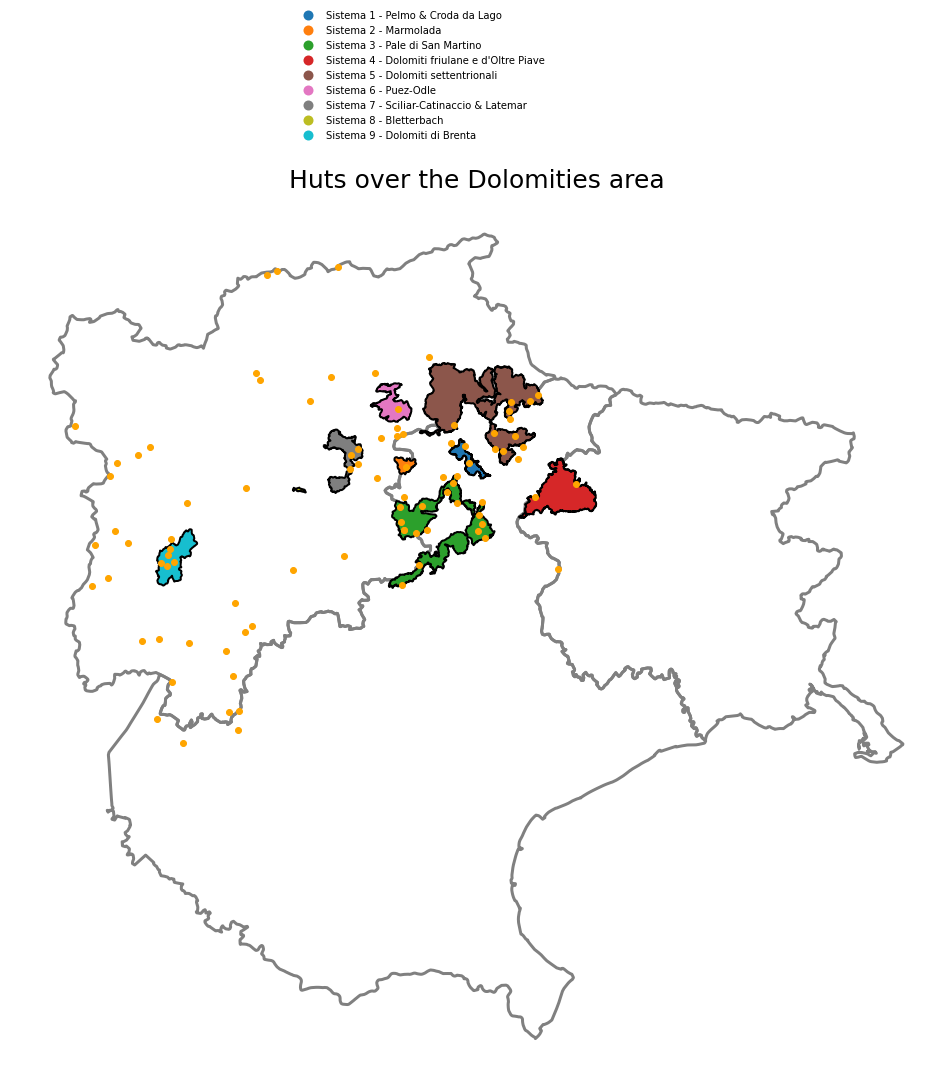

In [40]:
# explore with static maps
fig, axes = plt.subplots(1,1, figsize=(15,15))

dolomiti_regions.to_crs(epsg=4326).plot(ax=axes,  linewidth=3, facecolor='none', edgecolor='gray')
dolomiti_df.to_crs(epsg=4326).plot(
    ax=axes,
    linewidth=2,
    edgecolor='black',
    column='name',
    cmap = "tab10",
    legend=True,  
    categorical=True,
    legend_kwds= {
        'bbox_to_anchor':(.3, 1.05),
        'fontsize':10,
        'frameon':False
        }
)

cai_rifugi.to_crs(epsg=4326).plot(ax=axes, color = "orange")

plt.title('Huts over the Dolomities area', fontdict=dict(size=25))
plt.tight_layout()
plt.axis('off')
plt.show()